In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import linsolve
import uvtools
import pyuvdata
import glob
from astropy.io import fits
from pygsm import GSMObserver
from scipy import interpolate
from datetime import datetime
from astropy.time import Time
from astropy.coordinates import EarthLocation
import healpy as hp
from scipy.ndimage import filters
from astropy import constants as const
import os
from hera_qm import xrfi
from hera_qm import utils as qm_utils
import copy
from matplotlib.colors import SymLogNorm
from pyuvdata import UVBeam

In [2]:
class TskySim():
    """ Class to run Tsky Simulations"""
    def __init__(self, Tsky_file=None, beam_file=None, df=1.0, f_min=100.0, f_max=200.0, dlst=0.5,
                 pols=['E', 'N'], lat=-30.7224, lon=21.4278, elev=1100):
        """
        Initialize class
        Args:
            Tsky_file: Filename of npz file calculated from this class
            beam_file: Filename of fits file with beam
            df: channel width (MHz)
            f_min: minimum frequency (MHz)
            f_max: maximum frequency (MHz)
            dlst: LST separation (hours) Note, assume simulating 24 hours.
            pols: Polarizations
            lat: Latitude (degrees)
            lon: Longitude (degrees)
            elev: Elevation (feet?)
        """
        self.Tsky_file = Tsky_file
        self.beam_file = beam_file
        self.df = df
        self.f_min = f_min
        self.f_max = f_max
        self.dlst = dlst
        self.pols = pols
        self.lat = lat
        self.lon = lon
        self.elev = elev
        
        if self.Tsky_file is None:
            self.Tsky = None
            self.update_options()
        else:
            self.read_Tsky()

    def update_options(self):
        self.freqs = np.arange(self.f_min, self.f_max + self.df / 2.0, self.df)
        self.hours = np.arange(0.0, 24.0, self.dlst)
        self.lsts = np.zeros_like(self.hours)
        
    def read_Tsky(self):
        d = np.load(self.Tsky_file)
        self.freqs = d['freqs']
        self.lsts = d['lsts']
        self.Tsky = d['Tsky']
        self.pols = d['pols']
        try:
            self.Ae = d['Ae']
        except KeyError:
            print('Warning: Effective area not read from file.')

    def write_Tsky(self):
        np.savez(self.Tsky_file, Tsky=self.Tsky, freqs=self.freqs, lsts=self.lsts, pols=self.pols, Ae=self.Ae)
        
    def calc_Tsky(self):
        """
        Calculate the Tsky sim based on beam file and the GSM
        """
        if self.beam_file is None:
            raise(ValueError('Beam file is not defined, cannot compute Tsky simulation.'))
        # Otherwise go ahead and calculate
        self.Tsky = np.zeros((len(self.pols), len(self.freqs), len(self.lsts)))
        
        # First set up beam
        uvb = UVBeam()
        uvb.read_beamfits(self.beam_file)
        beam = {}
        rot_pol = {}
        #temp_f = fits.getdata(self.beam_file, extname='FREQS')
        temp_f = uvb.freq_array[0]*1e-6
        for i, pol in enumerate(self.pols):
            '''try:
                im = fits.getdata(self.beam_file, extname='BEAM_{0}'.format(pol))
                rot_pol[pol] = False
            except KeyError:
                # My example file only has one pol, need to rotate it (later)
                im = fits.getdata(self.beam_file, extname='BEAM_{0}'.format(self.pols[1 - i]))
                rot_pol[pol] = True
            func = interpolate.interp1d(temp_f, im, kind='cubic', axis=1)
            beam[pol] = func(self.freqs)'''
            rot_pol[pol] = False
            im = uvb.data_array[0,0,i].transpose()
            func = interpolate.interp1d(temp_f, im, kind='cubic', axis=1)
            beam[pol] = func(self.freqs)
            
            
        # Get the effective area
        self.Ae = np.zeros((len(self.pols), len(self.freqs)))
        for poli, pol in enumerate(self.pols):
            self.Ae[poli] = ((const.c.to('m*MHz').value / self.freqs)**2. /
                             (4 * np.pi / im.shape[0] * np.sum(beam[pol], axis=0) /
                              np.max(beam[pol], axis=0)))
        
        # Set up observer
        ov = GSMObserver()
        ov.lon = str(self.lon)
        ov.lat = str(self.lat)
        ov.elev = self.elev
        
        fig = plt.figure('Tsky_calc')  # Never found a way to not open a figure...
        for poli, pol in enumerate(self.pols):
            for fi, freq in enumerate(self.freqs):
                if rot_pol[pol]:
                    pol_ang = 0.0
                else:
                    pol_ang = 90.0
                temp_beam = hp.orthview(beam[pol][:, fi], rot=[pol_ang, 90], fig=fig.number,
                                        xsize=400, return_projected_map=True, half_sky=True)
                temp_beam[np.isinf(temp_beam)] = np.nan
                for ti, t in enumerate(self.hours):
                    plt.clf()
                    dt = datetime(2013, 1, 1, np.int(t), np.int(60.0 * (t - np.floor(t))),
                                  np.int(60.0 * (60.0 * t - np.floor(t * 60.0))))
                    self.lsts[ti] = Time(dt).sidereal_time('apparent', self.lon).hour
                    ov.date = dt
                    ov.generate(freq)
                    d = ov.view(fig=fig.number)
                    sky = hp.orthview(d, fig=fig.number, xsize=400, return_projected_map=True, half_sky=True)
                    sky[np.isinf(sky)] = np.nan
                    self.Tsky[poli, fi, ti] = np.nanmean(temp_beam * sky) / np.nanmean(temp_beam)
        
        inds = np.argsort(self.lsts)
        self.lsts = self.lsts[inds]
        self.Tsky = self.Tsky[:, :, inds]
        
    def build_model(self, buffer=10):
        """
        Create interpolation model for calculating Tsky and Ae at any frequency/LST.
        
        Args:
            buffer: (int) size of wrapping buffer to avoid edge effects in LST interpolation.
        """
        # Pad to avoid edge effects
        temp_lsts = np.concatenate([self.lsts[-buffer:] - 24., self.lsts, self.lsts[:buffer] + 24.])
        temp_Tsky = np.concatenate([self.Tsky[:, :, -buffer:], self.Tsky, self.Tsky[:, :, :buffer]], axis=2)
        self.mdl = {}
        self.mdlAe = {}
        for poli, pol in enumerate(self.pols):
            self.mdl[pol] = interpolate.RectBivariateSpline(self.freqs, temp_lsts, temp_Tsky[poli, :, :])
            self.mdlAe[pol] = interpolate.interp1d(self.freqs, self.Ae[poli])


In [3]:
class auto_data():
    """ Class to hold auto correlation data """
    def __init__(self, data_dir='/data6/HERA/data/2458042/KM_uvR_files/', filestart='zen.*',
                 dpols=['xx', 'yy'], fileend='*.uvR', autos_file='IDR1_autos.uvR',f_min = 100.0, f_max = 200.0):
        self.data_dir = data_dir
        self.autos_file = autos_file
        self.dpols = dpols
        self.pol_map = {'xx': 'E', 'yy': 'N'}
        self.pols = np.array([self.pol_map[p] for p in self.dpols])
        self.rev_pol_map = {'E': 'xx', 'N': 'yy'}
        # Read in data
        self.filestart = filestart
        self.fileend = fileend
        self.read_data()
        self.update_freq_array(f_min,f_max)
        
    def read_data(self, force_read=False):
        self.uv = pyuvdata.UVData()
        if os.path.exists(self.data_dir + self.autos_file) and not force_read:
            self.uv.read(self.data_dir + self.autos_file)
            
        else:
            file_lists = np.sort(glob.glob(self.data_dir + self.filestart + self.fileend))
            uv_temp = pyuvdata.UVData()
            for i in range(len(file_lists)):
                if i == 0:
                    self.uv.read([file_lists[i]])
                    self.uv.select(ant_str='auto')
                else:
                    uv_temp.read([file_lists[i]])
                    uv_temp.select(ant_str='auto')
                    self.uv += uv_temp
            self.uv.write_uvh5(self.data_dir + self.autos_file)
            
        '''else:
            file_lists = []
            for pol in self.pols:
                file_lists.append(np.sort(glob.glob(self.data_dir + self.filestart +self.rev_pol_map[pol] + self.fileend)))
                
            if len(file_lists[0]) != len(file_lists[1]):
                print('File list lengths are not the same!')
            uv_temp = pyuvdata.UVData()
            for i in range(len(file_lists[0])):
                if i == 0:
                    self.uv.read([file_lists[0][i], file_lists[1][i]])
                    self.uv.select(ant_str='auto')
                else:
                    uv_temp.read([file_lists[0][i], file_lists[1][i]])
                    uv_temp.select(ant_str='auto')
                    self.uv += uv_temp
            self.uv.write_uvh5(self.data_dir + self.autos_file)'''
            
        # Get some useful parameters
        self.lsts, ind = np.unique(self.uv.lst_array, return_index=True)
        order = np.argsort(ind)
        self.lsts = 24 * self.lsts[order] / (2 * np.pi)
        self.wrap = np.argmax(self.lsts)
        self.freqs = self.uv.freq_array.flatten() * 1e-6
        self.ants = self.uv.get_ants()
        
    def update_freq_array(self,f_min,f_max):
        '''
        Remove frequencies outside of the range (MHz) given by user, regardless of
        frequencies in uv files.
        '''
        ind = 0
        while ind < len(self.freqs):
            if (self.freqs[ind] < f_min) or (self.freqs[ind] > f_max):
                self.freqs = np.delete(self.freqs,ind)
            else:
                ind += 1
        
    def build_model(self, sim):
        """
        Build model of Tsky that matches the data
        Args:
            sim: TskySim object with interpolation model already built
        """
        self.Tsky = np.zeros((len(self.pols), len(self.lsts), len(self.freqs)))
        self.Ae = np.zeros((len(self.pols), len(self.freqs)))
        self.Tsky_mean = np.zeros((len(self.pols), len(self.freqs)))
        for poli, pol in enumerate(self.pols):
            self.Tsky[poli, :, :] = np.concatenate([sim.mdl[pol](self.freqs, self.lsts[:self.wrap + 1]),
                                                    sim.mdl[pol](self.freqs, self.lsts[self.wrap + 1:])], axis=1).T
            self.Tsky_mean[poli, :] = self.Tsky[poli, :, :].mean(axis=0)
            self.Ae[poli, :] = sim.mdlAe[pol](self.freqs)
    
    def _fits2gTrxr(self, all_chans=True, ch=600):
        """ Quick function to get from linear solution to physical parameters."""
        if all_chans:
            Ae = self.Ae
        else:
            Ae = self.Ae[:, ch]
        for ant, pol in self.fits.keys():
            poli = np.where(self.pols == pol)[0][0]
            self.gains[(ant, pol)] = np.sqrt(Ae[poli] / 2761.3006 * self.fits[(ant, pol)][0])
            self.Trxr[(ant, pol)] = self.fits[(ant, pol)][1] / self.fits[(ant, pol)][0] - self.Tsky_mean[poli]
    
    def fit_data(self, all_chans=True, ch=600):
        """
        Fit gains and receiver temperatures based on LST evolution of signal fit to
        simulated Tsky.
        
        Args:
            all_chans: (bool) fit all channels if set to True (default, slow). 
                       Otherwise only fit channel ch (faster).
            ch:        (int) Only fit this channel number. Default 600.
                       Ignored if all_chans == True.
        """
        
        self.gains = {}
        self.Trxr = {}
        self.fits = {}
        for poli, pol in enumerate(self.pols):
            for ant in self.ants:
                data = np.abs(self.uv.get_data((ant, ant, self.rev_pol_map[pol])))
                flags = self.uv.get_flags((ant, ant, self.rev_pol_map[pol]))
                d_ls = {}
                w_ls = {}
                kwargs = {}
                freq_low = np.where(self.uv.freq_array*1e-6 == np.min(self.freqs))[1][0]
                freq_high = np.where(self.uv.freq_array*1e-6 == np.max(self.freqs))[1][0]                
                for i in range(self.lsts.size):
                    if all_chans:
                        # Solve for all channels at once
                        d_ls['Tsky%d*g+n' % i] = data[i, freq_low:(freq_high+1)]
                        w_ls['Tsky%d*g+n' % i] = 1 - flags[i, freq_low:(freq_high+1)]
                        kwargs['Tsky%d' % i] = self.Tsky[poli, i, :] - self.Tsky_mean[poli]
                    else:
                        # Only solve channel ch
                        d_ls['Tsky%d*g+n' % i] = data[i, ch]
                        w_ls['Tsky%d*g+n' % i] = 1 - flags[i, ch]
                        kwargs['Tsky%d' % i] = self.Tsky[poli, i, ch] - self.Tsky_mean[poli]
                ls = linsolve.LinearSolver(d_ls, w_ls, **kwargs)
                sol = ls.solve()
                self.fits[(ant, pol)] = (sol['g'], sol['n'])
        self._fits2gTrxr(all_chans=all_chans, ch=ch)
    
    def data2Tsky(self, key):
        poli = np.where(self.pols == key[1])[0]
        freq_low = np.where(self.uv.freq_array*1e-6 == np.min(self.freqs))[1][0]
        freq_high = np.where(self.uv.freq_array*1e-6 == np.max(self.freqs))[1][0] 
        d = self.uv.get_data((key[0], key[0], self.rev_pol_map[key[1]]))[:,freq_low:(freq_high+1)]
        d = d / ((self.gains[key]**2. * 2761.3006 / self.Ae[poli]).reshape(1, -1)) - self.Trxr[key]
        return d


In [4]:

#Tsky_file = '/data4/shane/data/HERA_Tsky.npz'
Tsky_file_new = '/data4/shane/data/HERA_Tsky_vivaldi.npz'
hera_beam_file = '/home/shane/data/uv_beam_vivaldi.fits'


'''Tsky_sim = TskySim(beam_file=hera_beam_file,f_min=50,f_max=250.)
Tsky_sim.calc_Tsky()
# Save data for future runs
Tsky_sim.Tsky_file = Tsky_file_new
Tsky_sim.write_Tsky()'''


'Tsky_sim = TskySim(beam_file=hera_beam_file,f_min=50,f_max=250.)\nTsky_sim.calc_Tsky()\n# Save data for future runs\nTsky_sim.Tsky_file = Tsky_file_new\nTsky_sim.write_Tsky()'

In [4]:

foo = UVBeam()
vival = UVBeam()

foo.read_beamfits('/home/shane/data/uv_beam_test.fits')
vival.read_beamfits('/home/shane/data/uv_beam_vivaldi.fits')


In [5]:

foo_data = foo.data_array[0,0,0,50,:] / np.max(foo.data_array[0,0,0,50,:])

vival_data = vival.data_array[0,0,0,50,:] / np.max(vival.data_array[0,0,0,50,:])

diff = vival_data-foo_data

In [6]:
foo.freq_array[0,50]

100000000.0

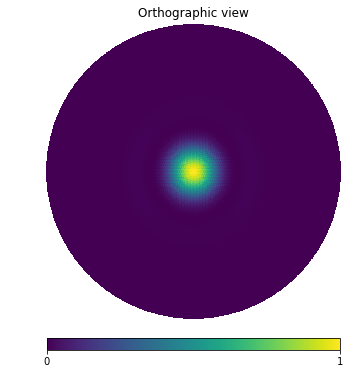

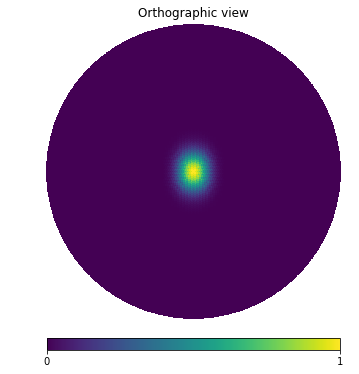

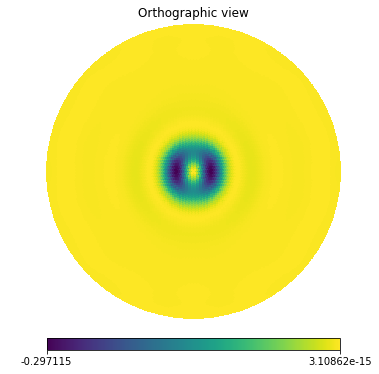

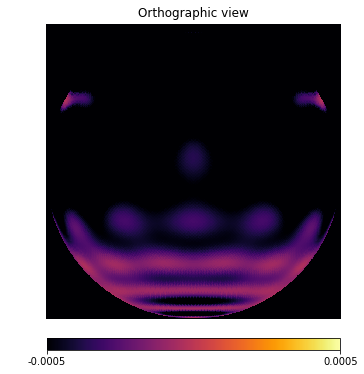

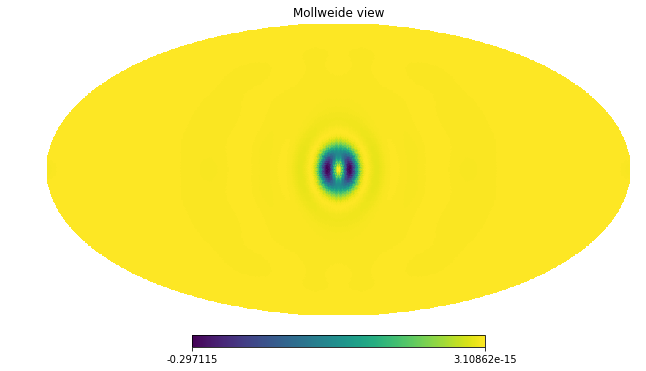

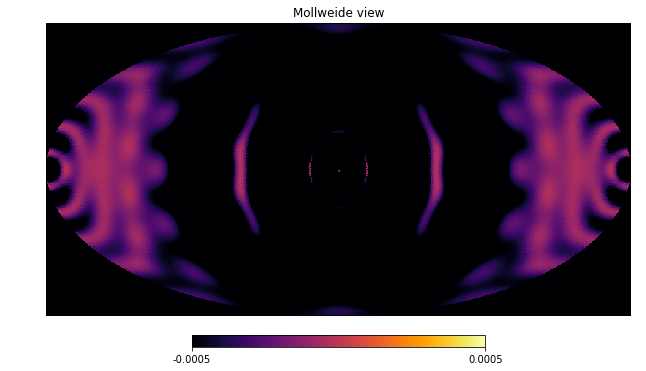

In [7]:
cmap='inferno'
hp.orthview(foo_data, half_sky=True,rot=(0,90,0),min=0,max=1)
hp.orthview(vival_data, half_sky=True,rot=(0,90,0),min=0,max=1)
hp.orthview(diff, half_sky=True,rot=(0,90,0))
hp.orthview(diff, half_sky=True,rot=(0,0,0),min=-0.0005,max=0.0005,cmap=cmap)
hp.mollview(diff,rot=(0,90,0))
hp.mollview(diff,rot=(0,90,0),min=-0.0005,max=0.0005,cmap=cmap)

# Testing Section

In [31]:

hera_beam_file = '/home/shane/data/uv_beam_vivaldi.fits'

Tsky_sim = TskySim(Tsky_file = '/data4/shane/data/HERA_Tsky_new_beam.npz', beam_file = hera_beam_file)

Tsky_low_sim = TskySim(Tsky_file = '/data4/shane/data/HERA_Tsky_new_beam_low.npz', beam_file = hera_beam_file,
                      f_min = 50.0, f_max = 100.0)

Tsky_test_sim = TskySim(Tsky_file = '/data4/shane/data/HERA_Tsky_new_beam_test.npz', beam_file = hera_beam_file,
                       f_min = 100.0, f_max = 150.0)

Tsky_old_beam_sim = TskySim(Tsky_file = '/data4/shane/data/HERA_Tsky.npz', 
                            beam_file = '/home/beards/code/HERA-Beams/NicolasFagnoniBeams/healpix_beam.fits')

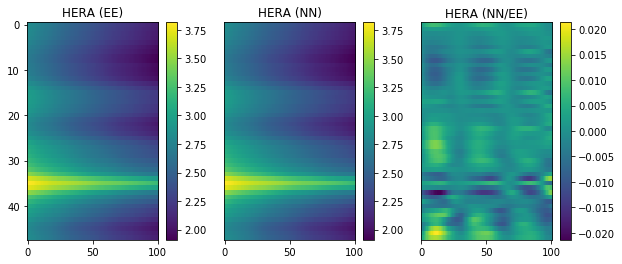

In [10]:
# Plot the Tsky sim: 100 - 200; new beam
plt.figure(figsize = (10, 4))
plt.subplot(131)
uvtools.plot.waterfall(Tsky_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_sim.pols[0] + Tsky_sim.pols[0] + ')')

plt.subplot(132)
uvtools.plot.waterfall(Tsky_sim.Tsky[1, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_sim.pols[1] + Tsky_sim.pols[1] + ')')
plt.yticks([])

plt.subplot(133)
uvtools.plot.waterfall(Tsky_sim.Tsky[1, :, :].T / Tsky_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + 2*Tsky_sim.pols[1] + '/' + 2*Tsky_sim.pols[0] + ')')
plt.yticks([])

plt.show()

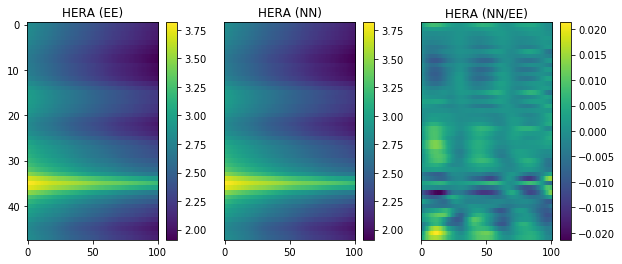

In [11]:
# Plot the Tsky sim: 100 - 200; old beam
plt.figure(figsize = (10, 4))
plt.subplot(131)
uvtools.plot.waterfall(Tsky_old_beam_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_old_beam_sim.pols[0] + Tsky_old_beam_sim.pols[0] + ')')

plt.subplot(132)
uvtools.plot.waterfall(Tsky_old_beam_sim.Tsky[1, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_old_beam_sim.pols[1] + Tsky_old_beam_sim.pols[1] + ')')
plt.yticks([])

plt.subplot(133)
uvtools.plot.waterfall(Tsky_old_beam_sim.Tsky[1, :, :].T / Tsky_old_beam_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + 2*Tsky_old_beam_sim.pols[1] + '/' + 2*Tsky_old_beam_sim.pols[0] + ')')
plt.yticks([])

plt.show()

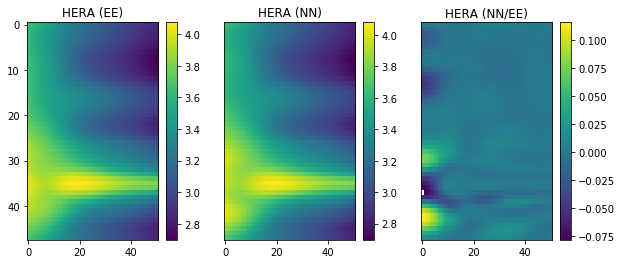

In [12]:
# Plot the Tsky sim: 50 - 100; new beam
plt.figure(figsize = (10, 4))
plt.subplot(131)
uvtools.plot.waterfall(Tsky_low_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_low_sim.pols[0] + Tsky_low_sim.pols[0] + ')')

plt.subplot(132)
uvtools.plot.waterfall(Tsky_low_sim.Tsky[1, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_low_sim.pols[1] + Tsky_low_sim.pols[1] + ')')
plt.yticks([])

plt.subplot(133)
uvtools.plot.waterfall(Tsky_low_sim.Tsky[1, :, :].T / Tsky_low_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + 2*Tsky_low_sim.pols[1] + '/' + 2*Tsky_low_sim.pols[0] + ')')
plt.yticks([])

plt.show()

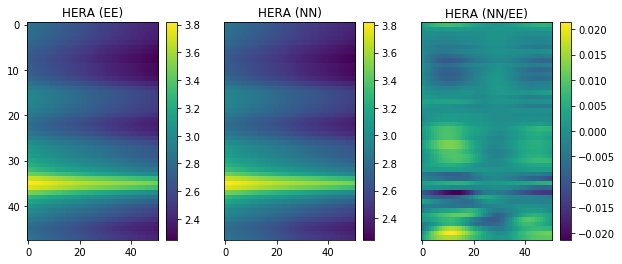

In [13]:
# Plot the Tsky sim: 100 - 150; new beam
plt.figure(figsize = (10, 4))
plt.subplot(131)
uvtools.plot.waterfall(Tsky_test_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_test_sim.pols[0] + Tsky_test_sim.pols[0] + ')')

plt.subplot(132)
uvtools.plot.waterfall(Tsky_test_sim.Tsky[1, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_test_sim.pols[1] + Tsky_test_sim.pols[1] + ')')
plt.yticks([])

plt.subplot(133)
uvtools.plot.waterfall(Tsky_test_sim.Tsky[1, :, :].T / Tsky_test_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + 2*Tsky_test_sim.pols[1] + '/' + 2*Tsky_test_sim.pols[0] + ')')
plt.yticks([])

plt.show()

In [14]:
diff_wf_0 = Tsky_sim.Tsky[0, :, :].T - Tsky_old_beam_sim.Tsky[0, :, :].T
diff_wf_1 = Tsky_sim.Tsky[1, :, :].T - Tsky_old_beam_sim.Tsky[1, :, :].T
diff_wf_2 = diff_wf_1/diff_wf_0

print diff_wf_2

[[ 2.06241356e+00 -6.54796013e-01  5.70638226e-01 ...  7.41140948e-01
  -1.69551634e-02 -4.12953356e+00]
 [-1.33863832e+02  2.91035871e-01  8.81158553e-01 ... -4.78270574e-01
  -1.88921777e+00 -2.37778243e+00]
 [-1.07427924e+01 -4.46919216e-02 -2.54570068e+00 ...  3.90622387e+00
  -7.46059701e+00  1.02416351e+00]
 ...
 [ 1.32537123e+00  6.70157564e-01  2.02060882e+00 ...  1.08751695e+00
   3.43032667e-02 -4.03337800e-02]
 [-4.55404327e-01 -1.69535001e-01  2.71236988e-02 ... -2.16461193e-01
   8.33671300e-01  1.47650779e-01]
 [-3.07699087e-02  1.34440044e+00  1.41803284e+00 ... -1.93756850e+00
  -3.52192050e+00 -5.51312193e-01]]


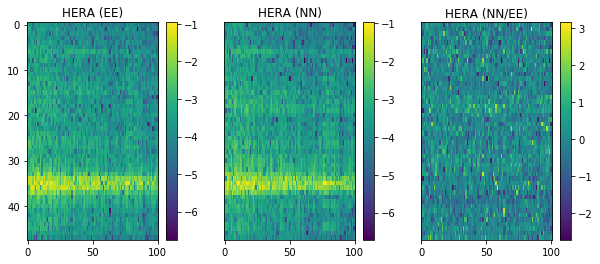

In [15]:
# Plot the Tsky sim: Diff of New/Old Beam; 100 - 200 MHz
plt.figure(figsize = (10, 4))
plt.subplot(131)
uvtools.plot.waterfall(diff_wf_0)
plt.colorbar()
plt.title('HERA (' + Tsky_sim.pols[0] + Tsky_sim.pols[0] + ')')

plt.subplot(132)
uvtools.plot.waterfall(diff_wf_1)
plt.colorbar()
plt.title('HERA (' + Tsky_sim.pols[1] + Tsky_sim.pols[1] + ')')
plt.yticks([])

plt.subplot(133)
uvtools.plot.waterfall(diff_wf_2)
plt.colorbar()
plt.title('HERA (' + 2*Tsky_sim.pols[1] + '/' + 2*Tsky_sim.pols[0] + ')')
plt.yticks([])

plt.show()

In [32]:
# Build interpolation models
Tsky_sim.build_model()
Tsky_test_sim.build_model()
Tsky_old_beam_sim.build_model()

In [33]:

IDR1_H1C_data = auto_data(data_dir='/data6/HERA/data/2458042/KM_uvR_files/', filestart='zen.*',
                          fileend='*.uvR', autos_file='IDR1_autos.uvR')

IDR1_H1C_data_test = auto_data(data_dir='/data6/HERA/data/2458042/KM_uvR_files/', filestart='zen.*',
                          fileend='*.uvR', autos_file='IDR1_autos.uvR',f_min = 100.0, f_max = 150.0)

IDR1_H1C_data_old = auto_data(data_dir='/data6/HERA/data/2458042/KM_uvR_files/', filestart='zen.*',
                          fileend='*.uvR', autos_file='IDR1_autos.uvR')

IDR1_H1C_data.build_model(Tsky_sim)

IDR1_H1C_data_test.build_model(Tsky_test_sim)

IDR1_H1C_data_old.build_model(Tsky_old_beam_sim)


KeyboardInterrupt: 

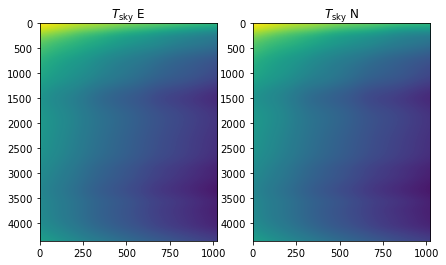

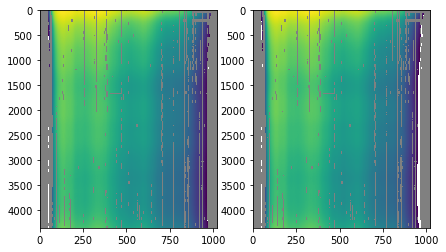

In [20]:
# Plot
chosen_ant = 24  # corresponds to ant9 from H19, which I plotted in memo
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(IDR1_H1C_data.pols):
    plt.subplot(1, 2, poli + 1)
    uvtools.plot.waterfall(IDR1_H1C_data.Tsky[poli], drng=2)
    plt.title('$T_{\\rm sky}$ ' + pol)

# Compare with a baseline
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(Tsky_sim.pols):
    plt.subplot(1, 2, poli + 1)
    data = np.ma.masked_where(IDR1_H1C_data.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data.rev_pol_map[pol])),
                              IDR1_H1C_data.uv.get_data((chosen_ant, chosen_ant, IDR1_H1C_data.rev_pol_map[pol])))
    uvtools.plot.waterfall(data, drng=2)

divide by zero encountered in log10


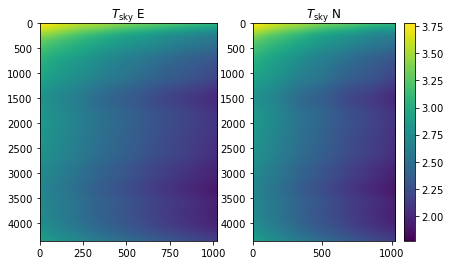

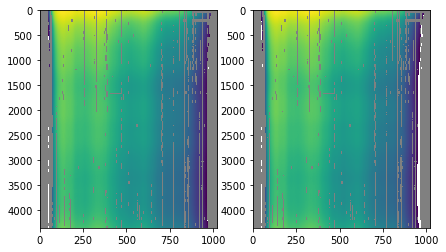

In [18]:
# Plot
chosen_ant = 24  # corresponds to ant9 from H19, which I plotted in memo
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(IDR1_H1C_data_old.pols):
    plt.subplot(1, 2, poli + 1)
    uvtools.plot.waterfall(IDR1_H1C_data_old.Tsky[poli], drng=2)
    plt.title('$T_{\\rm sky}$ ' + pol)
    
plt.colorbar()

# Compare with a baseline
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(Tsky_old_beam_sim.pols):
    plt.subplot(1, 2, poli + 1)
    data_old = np.ma.masked_where(IDR1_H1C_data_old.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data_old.rev_pol_map[pol])),
                              IDR1_H1C_data_old.uv.get_data((chosen_ant, chosen_ant, IDR1_H1C_data_old.rev_pol_map[pol])))
    uvtools.plot.waterfall(data_old, drng=2)

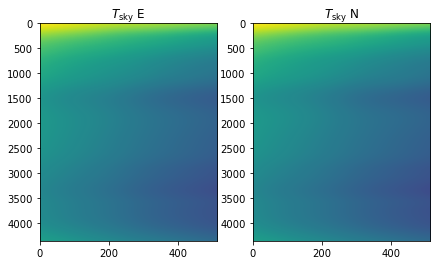

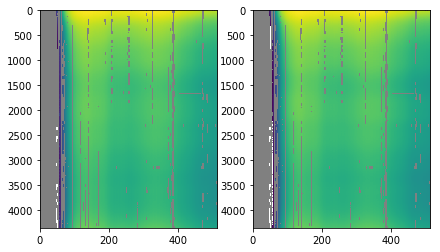

In [19]:
# Plot
chosen_ant = 24  # corresponds to ant9 from H19, which I plotted in memo
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(IDR1_H1C_data_test.pols):
    plt.subplot(1, 2, poli + 1)
    uvtools.plot.waterfall(IDR1_H1C_data_test.Tsky[poli], drng=2)
    plt.title('$T_{\\rm sky}$ ' + pol)

# Compare with a baseline
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(Tsky_test_sim.pols):
    plt.subplot(1, 2, poli + 1)
    data_test = np.ma.masked_where(IDR1_H1C_data_test.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data_test.rev_pol_map[pol])),
                              IDR1_H1C_data_test.uv.get_data((chosen_ant, chosen_ant, IDR1_H1C_data_test.rev_pol_map[pol])))
    uvtools.plot.waterfall(data_test[:,:513], drng=2)

In [176]:
IDR1_H1C_data.fit_data()

invalid value encountered in divide


In [177]:
IDR1_H1C_data_old.fit_data()

invalid value encountered in divide


In [178]:
IDR1_H1C_data_test.fit_data()

invalid value encountered in divide


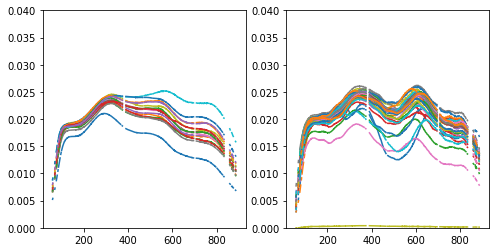

In [179]:
plt.figure(figsize=(8,4))
nrao_list = [51, 65, 66, 70, 82, 83, 98, 120, 121, 122, 123, 124, 141, 142, 143]
for ant in IDR1_H1C_data.ants:
    if ant in nrao_list:
        plt.subplot(121)
    else:
        plt.subplot(122)
    #plt.plot(filters.gaussian_filter1d(IDR1_H1C_data.gains[(ant, 'E')], 5))
    g = IDR1_H1C_data.gains[(ant, 'E')]
    g = np.where(g == 0, np.nan, g)
    plt.plot(g)
plt.subplot(121)
plt.ylim([0, .04])
plt.subplot(122)
plt.ylim([0, .04]);

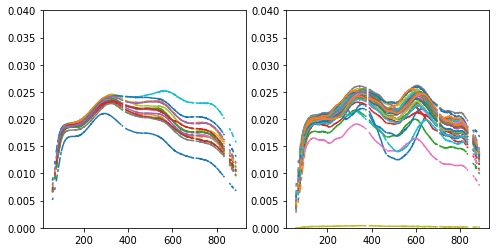

In [180]:
plt.figure(figsize=(8,4))
nrao_list = [51, 65, 66, 70, 82, 83, 98, 120, 121, 122, 123, 124, 141, 142, 143]
for ant in IDR1_H1C_data_old.ants:
    if ant in nrao_list:
        plt.subplot(121)
    else:
        plt.subplot(122)
    #plt.plot(filters.gaussian_filter1d(IDR1_H1C_data.gains[(ant, 'E')], 5))
    g = IDR1_H1C_data_old.gains[(ant, 'E')]
    g = np.where(g == 0, np.nan, g)
    plt.plot(g)
plt.subplot(121)
plt.ylim([0, .04])
plt.subplot(122)
plt.ylim([0, .04]);

In [214]:

diff_array = []

for key in IDR1_H1C_data.gains.keys():
    
    diff_array.append(np.abs(IDR1_H1C_data.gains[key]-IDR1_H1C_data_old.gains[key]))
    
print np.max(np.array(diff_array))


1.2509824734798641e-05


In [186]:
print IDR1_H1C_data.Tsky-IDR1_H1C_data_old.Tsky

[[[-2.26908665e-02 -1.71285671e-02 -1.24699135e-02 ... -1.04983685e-02
   -1.26672644e-02 -1.51476170e-02]
  [-2.32216454e-02 -1.75867135e-02 -1.28554637e-02 ... -1.05296423e-02
   -1.26977017e-02 -1.51770307e-02]
  [-2.37499726e-02 -1.80427481e-02 -1.32392599e-02 ... -1.05600239e-02
   -1.27270900e-02 -1.52052144e-02]
  ...
  [-3.80348845e-04  1.84335589e-05  3.58175375e-04 ...  1.26869050e-04
    1.75524005e-04  2.45590622e-04]
  [-3.91656041e-04  1.33281451e-05  3.58111942e-04 ...  1.26393088e-04
    1.75435394e-04  2.46005392e-04]
  [-4.02747365e-04  8.31053057e-06  3.58031761e-04 ...  1.25915336e-04
    1.75343376e-04  2.46413466e-04]]

 [[-1.96502916e-03 -1.55144648e-02 -2.58077596e-02 ... -2.29996018e-03
   -1.08028793e-03  3.29087028e-04]
  [-2.25519711e-03 -1.58821115e-02 -2.62190540e-02 ... -2.34413369e-03
   -1.11181334e-03  3.12400530e-04]
  [-2.54331901e-03 -1.62456700e-02 -2.66248137e-02 ... -2.38789458e-03
   -1.14309049e-03  2.95777181e-04]
  ...
  [ 3.33151038e-04  1.4

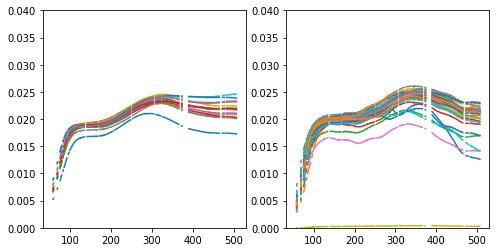

In [191]:
plt.figure(figsize=(8,4))
nrao_list = [51, 65, 66, 70, 82, 83, 98, 120, 121, 122, 123, 124, 141, 142, 143]
for ant in IDR1_H1C_data_test.ants:
    if ant in nrao_list:
        plt.subplot(121)
    else:
        plt.subplot(122)
    #plt.plot(filters.gaussian_filter1d(IDR1_H1C_data_test.gains[(ant, 'E')], 5))
    g_test = IDR1_H1C_data_test.gains[(ant, 'E')]
    g_test = np.where(g_test == 0, np.nan, g_test)
    plt.plot(g_test)
plt.subplot(121)
plt.ylim([0, .04])
plt.subplot(122)
plt.ylim([0, .04]);

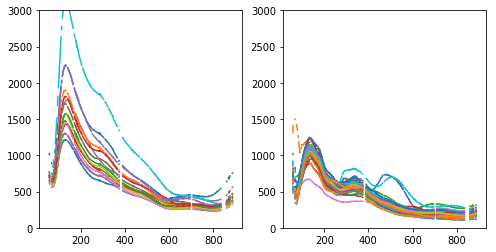

In [192]:
plt.figure(figsize=(8,4))
for ant in IDR1_H1C_data.ants:
    if ant in nrao_list:
        plt.subplot(121)
    else:
        plt.subplot(122)
    t = IDR1_H1C_data.Trxr[(ant, 'E')]
    t = np.where(t==0, np.nan, t)
    plt.plot(t)
plt.subplot(121)
plt.ylim([0, 3e3])
plt.subplot(122)
plt.ylim([0, 3e3]);

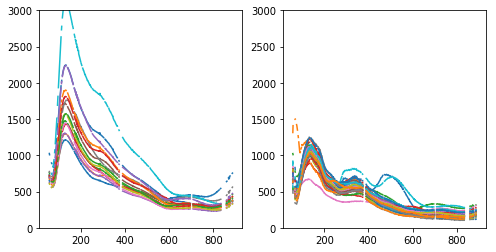

In [193]:
plt.figure(figsize=(8,4))
for ant in IDR1_H1C_data_old.ants:
    if ant in nrao_list:
        plt.subplot(121)
    else:
        plt.subplot(122)
    t = IDR1_H1C_data_old.Trxr[(ant, 'E')]
    t = np.where(t==0, np.nan, t)
    plt.plot(t)
plt.subplot(121)
plt.ylim([0, 3e3])
plt.subplot(122)
plt.ylim([0, 3e3]);

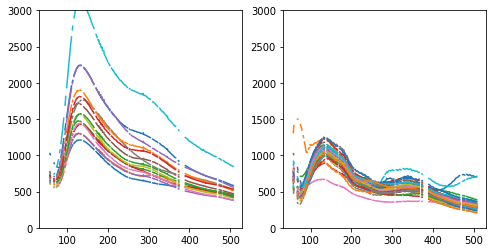

In [206]:
plt.figure(figsize=(8,4))
for ant in IDR1_H1C_data_test.ants:
    if ant in nrao_list:
        plt.subplot(121)
    else:
        plt.subplot(122)
    t_test = IDR1_H1C_data_test.Trxr[(ant, 'E')]
    t_test = np.where(t_test==0, np.nan, t_test)
    plt.plot(t_test)
plt.subplot(121)
plt.ylim([0, 3e3])
plt.subplot(122)
plt.ylim([0, 3e3]);

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


Text(0.5,0,u'LST (Hours)')

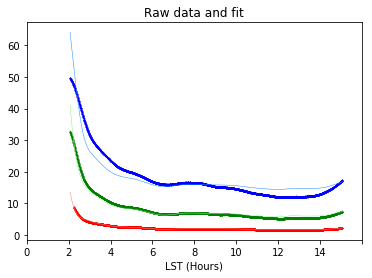

In [101]:
# Plot data vs corrupted Tsky
plt.figure()
chosen_ant = 24
dark_colors = ['blue', 'green', 'red']
light_colors = ['dodgerblue', 'lightgreen', 'salmon']
poli = 0
pol = IDR1_H1C_data.pols[poli]
chans = [166, 500, 872]  # Correspond to what's plotted in memo
d = np.ma.masked_where(IDR1_H1C_data.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data.rev_pol_map[pol])),
                       IDR1_H1C_data.uv.get_data((chosen_ant, chosen_ant, IDR1_H1C_data.rev_pol_map[pol])))
plot_lsts = np.concatenate([IDR1_H1C_data.lsts[:(IDR1_H1C_data.wrap+1)]-24, IDR1_H1C_data.lsts[(IDR1_H1C_data.wrap+1):]])
for i, chan in enumerate(chans):
    d_plot = d[:, chan]
    plt.plot(plot_lsts, d_plot, '.', ms=1, color=dark_colors[i])
    mdl_plot = ((IDR1_H1C_data.Tsky[poli, :, chan] - IDR1_H1C_data.Tsky_mean[poli][chan]) *
                IDR1_H1C_data.fits[(chosen_ant, pol)][0][chan] + IDR1_H1C_data.fits[(chosen_ant, pol)][1][chan])
    plt.plot(plot_lsts, mdl_plot, linewidth=0.5, color=light_colors[i])
plt.title('Raw data and fit')
plt.xticks(plt.xticks()[0],[0,2,4,6,8,10,12,14])
plt.xlabel('LST (Hours)')

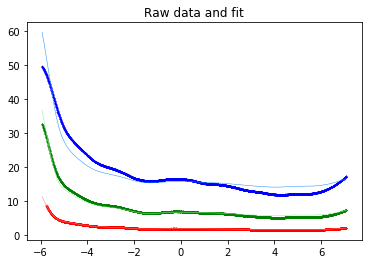

In [196]:
# Plot data vs corrupted Tsky
plt.figure()
chosen_ant = 24
dark_colors = ['blue', 'green', 'red']
light_colors = ['dodgerblue', 'lightgreen', 'salmon']
poli = 0
pol = IDR1_H1C_data_old.pols[poli]
chans = [166, 500, 872]  # Correspond to what's plotted in memo
d = np.ma.masked_where(IDR1_H1C_data_old.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data_old.rev_pol_map[pol])),
                       IDR1_H1C_data_old.uv.get_data((chosen_ant, chosen_ant, IDR1_H1C_data_old.rev_pol_map[pol])))
plot_lsts = np.concatenate([IDR1_H1C_data_old.lsts[:(IDR1_H1C_data_old.wrap+1)]-24, IDR1_H1C_data_old.lsts[(IDR1_H1C_data_old.wrap+1):]])
for i, chan in enumerate(chans):
    d_plot = d[:, chan]
    plt.plot(plot_lsts, d_plot, '.', ms=1, color=dark_colors[i])
    mdl_plot = ((IDR1_H1C_data_old.Tsky[poli, :, chan] - IDR1_H1C_data_old.Tsky_mean[poli][chan]) *
                IDR1_H1C_data_old.fits[(chosen_ant, pol)][0][chan] + IDR1_H1C_data_old.fits[(chosen_ant, pol)][1][chan])
    plt.plot(plot_lsts, mdl_plot, linewidth=0.5, color=light_colors[i])
plt.title('Raw data and fit');

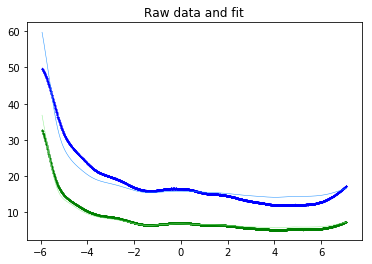

In [197]:
# Plot data vs corrupted Tsky
plt.figure()
chosen_ant = 24
dark_colors = ['blue', 'green', 'red']
light_colors = ['dodgerblue', 'lightgreen', 'salmon']
poli = 0
pol = IDR1_H1C_data.pols[poli]
chans = [166, 500]  # Correspond to what's plotted in memo
d = np.ma.masked_where(IDR1_H1C_data_test.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data_test.rev_pol_map[pol])),
                       IDR1_H1C_data_test.uv.get_data((chosen_ant, chosen_ant, IDR1_H1C_data_test.rev_pol_map[pol])))
plot_lsts = np.concatenate([IDR1_H1C_data_test.lsts[:(IDR1_H1C_data_test.wrap+1)]-24, IDR1_H1C_data_test.lsts[(IDR1_H1C_data_test.wrap+1):]])
for i, chan in enumerate(chans):
    d_plot = d[:, chan]
    plt.plot(plot_lsts, d_plot, '.', ms=1, color=dark_colors[i])
    mdl_plot = ((IDR1_H1C_data_test.Tsky[poli, :, chan] - IDR1_H1C_data_test.Tsky_mean[poli][chan]) *
                IDR1_H1C_data_test.fits[(chosen_ant, pol)][0][chan] + IDR1_H1C_data_test.fits[(chosen_ant, pol)][1][chan])
    plt.plot(plot_lsts, mdl_plot, linewidth=0.5, color=light_colors[i])
plt.title('Raw data and fit');

divide by zero encountered in divide
invalid value encountered in divide


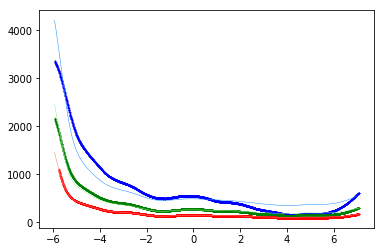

In [198]:

# Plot estimate for Tsky# Plot es 
plt.figure()
chosen_ant = 24
dark_colors = ['blue', 'green', 'red']
light_colors = ['dodgerblue', 'lightgreen', 'salmon']
poli = 0
pol = IDR1_H1C_data.pols[poli]
chans = [166, 500, 872]  # Correspond to what's plotted in memo
d = np.ma.masked_where(IDR1_H1C_data.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data.rev_pol_map[pol])),
                       IDR1_H1C_data.data2Tsky((chosen_ant, pol)))
plot_lsts = np.concatenate([IDR1_H1C_data.lsts[:(IDR1_H1C_data.wrap+1)]-24, IDR1_H1C_data.lsts[(IDR1_H1C_data.wrap+1):]])
for i, chan in enumerate(chans):
    d_plot = d[:, chan]
    plt.plot(plot_lsts, d_plot, '.', ms=1, color=dark_colors[i])
    mdl_plot = IDR1_H1C_data.Tsky[poli, :, chan]
    plt.plot(plot_lsts, mdl_plot, linewidth=0.5, color=light_colors[i])

divide by zero encountered in divide
invalid value encountered in divide


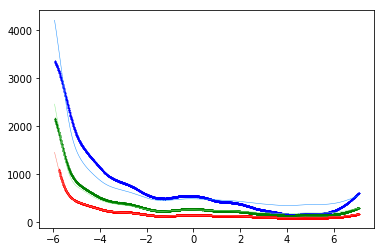

In [199]:

# Plot estimate for Tsky# Plot es 
plt.figure()
chosen_ant = 24
dark_colors = ['blue', 'green', 'red']
light_colors = ['dodgerblue', 'lightgreen', 'salmon']
poli = 0
pol = IDR1_H1C_data_old.pols[poli]
chans = [166, 500, 872]  # Correspond to what's plotted in memo
d = np.ma.masked_where(IDR1_H1C_data_old.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data_old.rev_pol_map[pol])),
                       IDR1_H1C_data_old.data2Tsky((chosen_ant, pol)))
plot_lsts = np.concatenate([IDR1_H1C_data_old.lsts[:(IDR1_H1C_data.wrap+1)]-24, IDR1_H1C_data_old.lsts[(IDR1_H1C_data_old.wrap+1):]])
for i, chan in enumerate(chans):
    d_plot = d[:, chan]
    plt.plot(plot_lsts, d_plot, '.', ms=1, color=dark_colors[i])
    mdl_plot = IDR1_H1C_data_old.Tsky[poli, :, chan]
    plt.plot(plot_lsts, mdl_plot, linewidth=0.5, color=light_colors[i])

divide by zero encountered in divide
invalid value encountered in divide


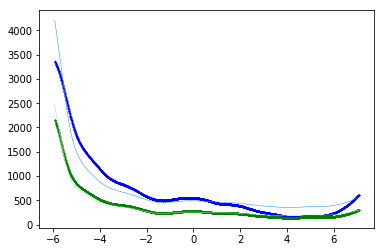

In [200]:

# Plot estimate for Tsky# Plot es 
plt.figure()
chosen_ant = 24
dark_colors = ['blue', 'green', 'red']
light_colors = ['dodgerblue', 'lightgreen', 'salmon']
poli = 0
pol = IDR1_H1C_data.pols[poli]
chans = [166, 500]  # Correspond to what's plotted in memo
freq_low = np.where(IDR1_H1C_data_test.uv.freq_array*1e-6 == np.min(IDR1_H1C_data_test.freqs))[1][0]
freq_high = np.where(IDR1_H1C_data_test.uv.freq_array*1e-6 == np.max(IDR1_H1C_data_test.freqs))[1][0]
d = np.ma.masked_where(IDR1_H1C_data_test.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data_test.rev_pol_map[pol]))[:,freq_low:(freq_high+1)],
                       IDR1_H1C_data_test.data2Tsky((chosen_ant, pol)))
plot_lsts = np.concatenate([IDR1_H1C_data_test.lsts[:(IDR1_H1C_data_test.wrap+1)]-24, IDR1_H1C_data_test.lsts[(IDR1_H1C_data_test.wrap+1):]])
for i, chan in enumerate(chans):
    d_plot = d[:, chan]
    plt.plot(plot_lsts, d_plot, '.', ms=1, color=dark_colors[i])
    mdl_plot = IDR1_H1C_data_test.Tsky[poli, :, chan]
    plt.plot(plot_lsts, mdl_plot, linewidth=0.5, color=light_colors[i])

# Vivaldi Feeds Tsky

In [5]:
hera_beam_file = '/home/shane/data/uv_beam_vivaldi.fits'

Tsky_sim = TskySim(Tsky_file = '/data4/shane/data/HERA_Tsky_vivaldi.npz', beam_file = hera_beam_file,
                  f_min=50,f_max=250)


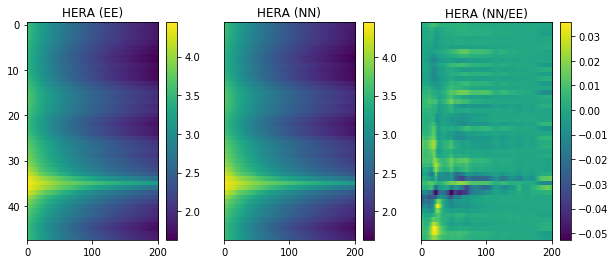

In [6]:
# Plot the Tsky sim: 50 - 250; vivaldi beam
plt.figure(figsize = (10, 4))
plt.subplot(131)
uvtools.plot.waterfall(Tsky_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_sim.pols[0] + Tsky_sim.pols[0] + ')')

plt.subplot(132)
uvtools.plot.waterfall(Tsky_sim.Tsky[1, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_sim.pols[1] + Tsky_sim.pols[1] + ')')
plt.yticks([])

plt.subplot(133)
uvtools.plot.waterfall(Tsky_sim.Tsky[1, :, :].T / Tsky_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + 2*Tsky_sim.pols[1] + '/' + 2*Tsky_sim.pols[0] + ')')
plt.yticks([])

plt.show()

In [7]:
Tsky_sim.build_model()

In [8]:

lowband_data = auto_data(data_dir='/data4/shane/data/2458504/', filestart='zen.*',
                         fileend='*HH.uvh5', autos_file='lowband_autos.uvh5',f_min=50.0,f_max=250.0)

lowband_data.build_model(Tsky_sim)

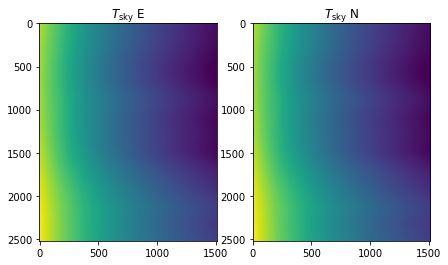

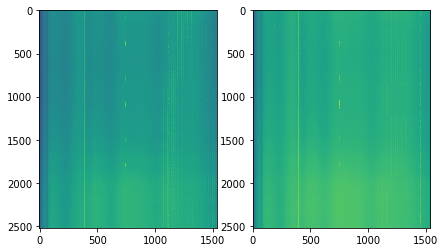

In [9]:
# Plot
chosen_ant = 1
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(lowband_data.pols):
    plt.subplot(1, 2, poli + 1)
    uvtools.plot.waterfall(lowband_data.Tsky[poli], drng=2)
    plt.title('$T_{\\rm sky}$ ' + pol)

# Compare with a baseline
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(Tsky_sim.pols):
    plt.subplot(1, 2, poli + 1)
    data = np.ma.masked_where(lowband_data.uv.get_flags((chosen_ant, chosen_ant, lowband_data.rev_pol_map[pol])),
                              lowband_data.uv.get_data((chosen_ant, chosen_ant, lowband_data.rev_pol_map[pol])))
    uvtools.plot.waterfall(data, drng=2)

 Flag Data

In [10]:
lowband_data.fit_data()

invalid value encountered in sqrt


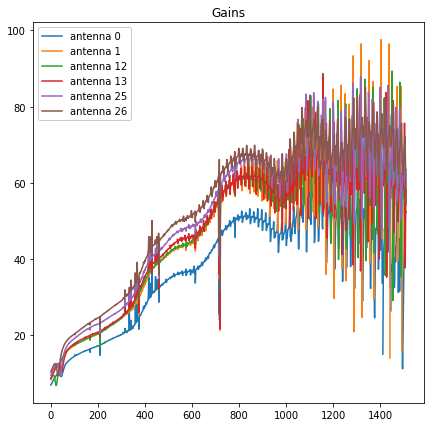

In [11]:
plt.figure(figsize = (7,7))
plt.plot(lowband_data.gains[(0,'E')],label='antenna 0')
plt.plot(lowband_data.gains[(1,'E')],label='antenna 1')
plt.plot(lowband_data.gains[(12,'E')],label='antenna 12')
plt.plot(lowband_data.gains[(13,'E')],label='antenna 13')
#plt.plot(lowband_data.gains[(14,'E')],label='antenna 14')
plt.plot(lowband_data.gains[(25,'E')],label='antenna 25')
plt.plot(lowband_data.gains[(26,'E')],label='antenna 26')
plt.legend(loc = 'upper left', framealpha = 1)
plt.title('Gains')
plt.show()

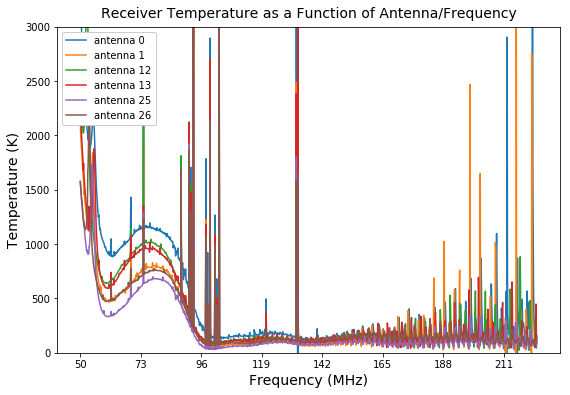

In [15]:
plt.figure(figsize = (9,6))
plt.plot(lowband_data.Trxr[(0,'E')],label='antenna 0')
plt.plot(lowband_data.Trxr[(1,'E')],label='antenna 1')
plt.plot(lowband_data.Trxr[(12,'E')],label='antenna 12')
plt.plot(lowband_data.Trxr[(13,'E')],label='antenna 13')
#plt.plot(lowband_data.Trxr[(14,'E')],label='antenna 14')
plt.plot(lowband_data.Trxr[(25,'E')],label='antenna 25')
plt.plot(lowband_data.Trxr[(26,'E')],label='antenna 26')
plt.ylim([0,3e3])
plt.legend(loc = 'upper left', framealpha = 1)
plt.title('Receiver Temperature as a Function of Antenna/Frequency',size=14,verticalalignment='bottom')
plt.xlabel('Frequency (MHz)',size=14)
plt.ylabel('Temperature (K)',size=14)
plt.xticks(plt.xticks()[0][1:-1],[50,50+23,50+23*2,50+23*3,50+23*4,50+23*5,50+23*6,50+23*7])
#plt.savefig('2458504_trxr_0.png')
plt.show()

Casting complex values to real discards the imaginary part


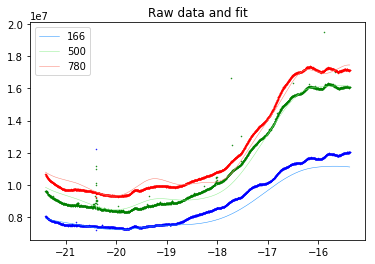

In [13]:
# Plot data vs corrupted Tsky
plt.figure()
chosen_ant = 1
dark_colors = ['blue', 'green', 'red']
light_colors = ['dodgerblue', 'lightgreen', 'salmon']
poli = 0
pol = lowband_data.pols[poli]
#chans = [166, 500, 872]  # Correspond to what's plotted in memo
chans = [166,500,780] # channel size 820
d = np.ma.masked_where(lowband_data.uv.get_flags((chosen_ant, chosen_ant, lowband_data.rev_pol_map[pol])),
                       lowband_data.uv.get_data((chosen_ant, chosen_ant, lowband_data.rev_pol_map[pol])))
plot_lsts = np.concatenate([lowband_data.lsts[:(lowband_data.wrap+1)]-24, lowband_data.lsts[(lowband_data.wrap+1):]])
for i, chan in enumerate(chans):
    d_plot = d[:, chan]
    plt.plot(plot_lsts, d_plot, '.', ms=1, color=dark_colors[i])
    mdl_plot = ((lowband_data.Tsky[poli, :, chan] - lowband_data.Tsky_mean[poli][chan]) *
                lowband_data.fits[(chosen_ant, pol)][0][chan] + lowband_data.fits[(chosen_ant, pol)][1][chan])
    plt.plot(plot_lsts, mdl_plot, linewidth=0.5, color=light_colors[i],label=str(chan))
plt.title('Raw data and fit')
plt.legend();

test
test


Casting complex values to real discards the imaginary part


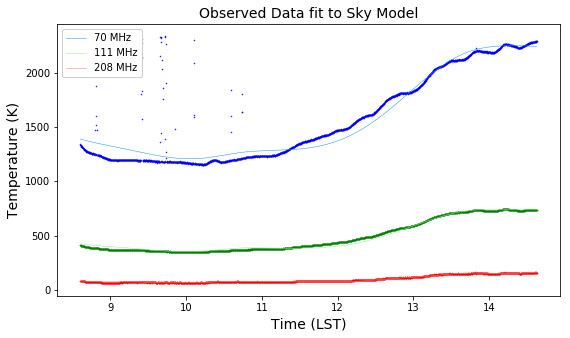

In [14]:

# Plot estimate for Tsky# Plot es 
plt.figure(figsize = (9,5))
chosen_ant = 1
dark_colors = ['blue', 'green', 'red']
light_colors = ['dodgerblue', 'lightgreen', 'salmon']
poli = 0
pol = lowband_data.pols[poli]
#chans = [166, 500, 872]  # Correspond to what's plotted in memo
chans = [166,500,1300]
#d = np.ma.masked_where(lowband_data.uv.get_flags((chosen_ant, chosen_ant, lowband_data.rev_pol_map[pol])),
                       #lowband_data.data2Tsky((chosen_ant, pol)))

d = np.array(lowband_data.data2Tsky((chosen_ant, pol)))
plot_lsts = np.concatenate([lowband_data.lsts[:(lowband_data.wrap+1)]-24, lowband_data.lsts[(lowband_data.wrap+1):]])
for i, chan in enumerate(chans):
    d_plot = d[:, chan]
    plt.plot(plot_lsts, d_plot, '.', ms=1, color=dark_colors[i])
    mdl_plot = lowband_data.Tsky[poli, :, chan]
    plt.plot(plot_lsts, mdl_plot, linewidth=0.5, color=light_colors[i],label=str(int(lowband_data.freqs[chan]))+' MHz')
plt.title('Observed Data fit to Sky Model',size = 14)
plt.xlabel('Time (LST)',size=14)
plt.ylabel('Temperature (K)',size=14)
plt.legend(loc = 'upper left', framealpha = 1)
plt.xticks(plt.xticks()[0][1:-1],[9,10,11,12,13,14])
#plt.ylim([0,800])
#plt.savefig("2458504_data_to_model.png")
plt.show()